In [12]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient('mongodb://localhost:27017/')
db = client.UniV3

swaps = db.swaps
users = db.users


In [13]:
swaps_count = swaps.count_documents({})
users_count = users.count_documents({})


In [14]:
aggregate_swaps_volume = users.aggregate(
    [{
        "$project": {
            "_id": "$_id",
            "volume_sum": {
                "$sum": {
                    "$reduce": {
                        "input": "$swaps.amountUSD",
                        "initialValue": 0,
                        "in": { "$add" : ["$$value", "$$this"] }
                    }
                }
            },
            "count": {
                "$size": "$swaps"
            }
        }
    },
    {
        "$project": {
            "_id": "$_id",
            "volume_sum": "$volume_sum",
            "count": "$count",
            "volume_avg": {
                "$divide": ["$volume_sum", "$count"]
            },
        }
    },
    {
        "$match": {
            "volume_sum": { "$lt": 1000000 },   # drop some user which has too large volume, like flashbot
        }
    }])

df = pd.DataFrame(list(aggregate_swaps_volume))
print("count", df.shape[0])
print(df.head())


count 139280
                                          _id     volume_sum  count  \
0  0x8cb50c2ab3c9108ac5d5199c9397f26eb9642253  420194.149453     21   
1  0x9b7ad9cb6207707cc70838c459d3185ddb4f6d00     182.046338      1   
2  0x634657e2db84c46e48fe63a62f242c8aa062cbd1    6502.061531      2   
3  0x291e84fcc2ac41b07dadf80722130d524e25443e     163.841665      1   
4  0x8bbcb4d259b0f52e4bcf32210cae0bc91a677cdb   93351.831780      8   

     volume_avg  
0  20009.245212  
1    182.046338  
2   3251.030765  
3    163.841665  
4  11668.978973  


In [15]:
volume_max = df['volume_sum'].max()
volume_min = df['volume_sum'].min()
print("volume_max", volume_max)
print("volume_min", volume_min)

volume_max 999899.0640799418
volume_min 1.000457667780938e-06


In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def getCounts(arr, bins):
    segments = pd.cut(arr, bins, right=False)
    counts = pd.value_counts(segments, sort=False)
    return counts

def drawBars(x, title="swaps num distribution"):
    plt.figure(figsize=(18, 8), layout='constrained')
    plt.axes(yscale="log")
    plt.bar(x.index.astype(str), x)  # Plot some data on the (implicit) axes.
    plt.xlabel('swaps volume bins')
    plt.ylabel('swaps volume')
    plt.title(title)

In [18]:
bins0 = []
bin0_width = 100000
for i in range(10):
    bins0.append(bin0_width * i)
bins0.append(volume_max)

counts_0 = getCounts(df['volume_sum'].to_list(), bins0)
print(counts_0.head(counts_0.shape[0]))

[0.0, 100000.0)           124106
[100000.0, 200000.0)        6887
[200000.0, 300000.0)        2967
[300000.0, 400000.0)        1711
[400000.0, 500000.0)        1163
[500000.0, 600000.0)         787
[600000.0, 700000.0)         590
[700000.0, 800000.0)         396
[800000.0, 900000.0)         372
[900000.0, 999899.064)       300
dtype: int64


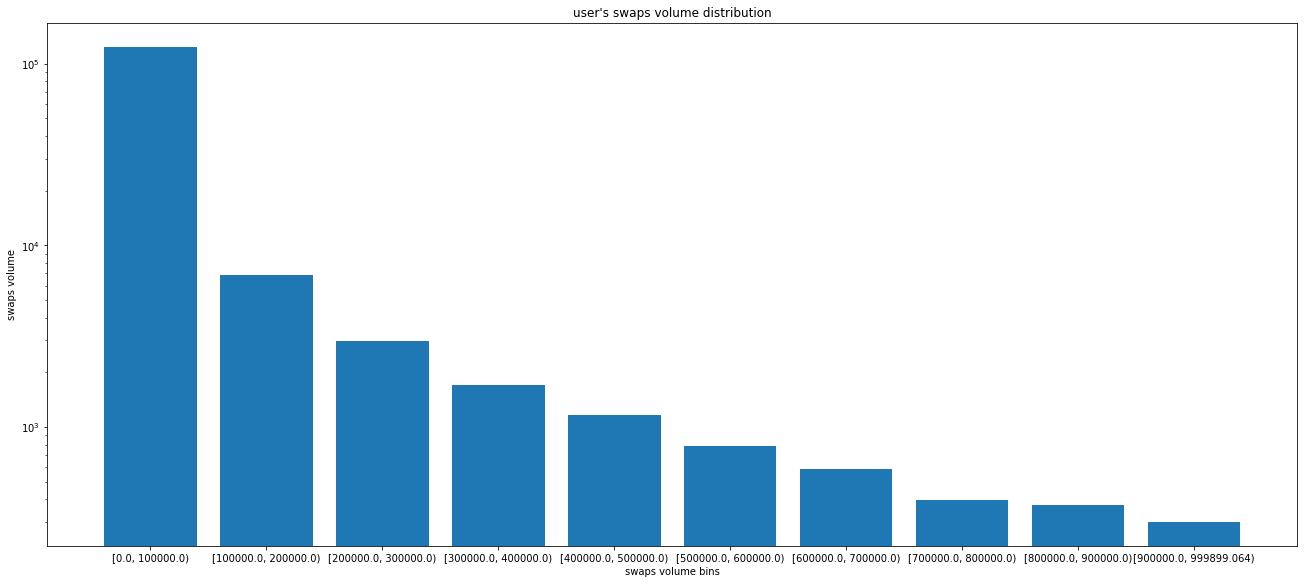

In [19]:
'''
user's swap volume distribution.
'''
drawBars(counts_0, "user's swaps volume distribution")

In [20]:
volume_avg_max = df['volume_avg'].max()
volume_avg_min = df['volume_avg'].min()
print("volume_avg_max", volume_avg_max)
print("volume_avg_min", volume_avg_min)

volume_avg_max 999899.0640799418
volume_avg_min 1.000457667780938e-06


In [21]:
bins1 = []
bin1_width = 100000
for i in range(10):
    bins1.append(bin1_width * i)
bins1.append(volume_avg_max)

counts_1 = getCounts(df['volume_avg'].to_list(), bins1)
print(counts_1.head(counts_1.shape[0]))

[0.0, 100000.0)           133504
[100000.0, 200000.0)        3513
[200000.0, 300000.0)        1121
[300000.0, 400000.0)         513
[400000.0, 500000.0)         330
[500000.0, 600000.0)         129
[600000.0, 700000.0)          65
[700000.0, 800000.0)          41
[800000.0, 900000.0)          36
[900000.0, 999899.064)        27
dtype: int64


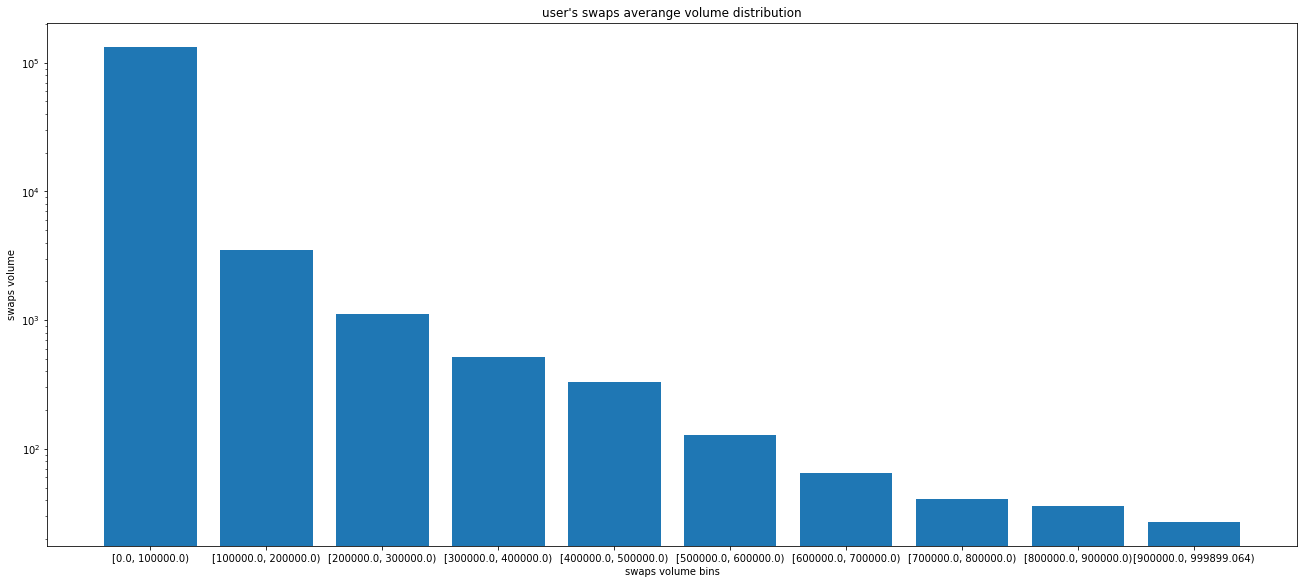

In [22]:
'''
user's swap averange volume distribution.
'''
drawBars(counts_1, "user's swaps averange volume distribution")